In [1]:
# 1. INSTALL & IMPORT LIBRARIES
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
import joblib

In [2]:
# 2. LOAD DATA
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/WELFake_Dataset.csv"  # Update path
df = pd.read_csv(file_path)

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]
print("Dataset shape:", df.shape)
df.head()

Mounted at /content/drive
Dataset shape: (72134, 4)


,unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
# 2: Data Preprocessing

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)                  # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)    # Remove URLs
    text = re.sub(r'<.*?>+', '', text)                   # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)                      # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)                 # Remove numbers
    return text

df['text'] = df['text'].apply(clean_text)

print("Text cleaning complete")
print(df.isnull().sum())

Text cleaning complete
unnamed: 0      0
title         558
text            0
label           0
dtype: int64


Dataset Overview:
         unnamed: 0         label
count  72134.000000  72134.000000
mean   36066.500000      0.514404
std    20823.436496      0.499796
min        0.000000      0.000000
25%    18033.250000      0.000000
50%    36066.500000      1.000000
75%    54099.750000      1.000000
max    72133.000000      1.000000
Label Distribution:
label
1    37106
0    35028
Name: count, dtype: int64


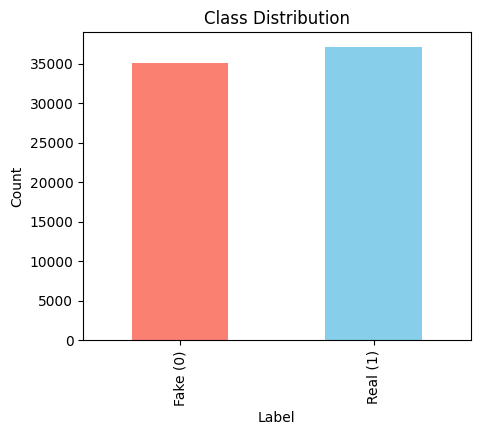

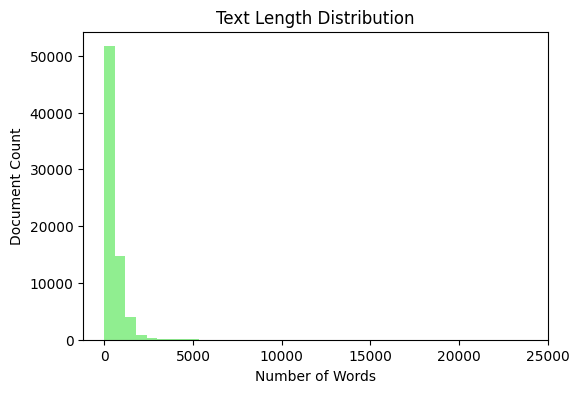

Example from label 1 (REAL):
 no comment is expected from barack obama members of the  or fukyoflag and blacklivesmatter movements called for the lynching and hanging of white people and cops they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing
Example from label 0 (FAKE):
 a dozen politically active pastors came here for a private dinner friday night to hear a conversion story unique in the context of presidential politics how louisiana gov bobby jindal traveled from hinduism to protestant christianity and ultimately became what he calls an “evangelical catholic”  ove


In [4]:
# 3: Dataset Overview and EDA

print("Dataset Overview:")
print(df.describe())
print("Label Distribution:")
print(df['label'].value_counts())

# Plot class distribution
plt.figure(figsize=(5,4))
df['label'].value_counts().sort_index().plot(kind='bar', color=['salmon', 'skyblue'])
plt.xticks([0,1], ['Fake (0)', 'Real (1)'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Word count distribution
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
plt.hist(df['text_len'], bins=40, color='lightgreen')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Document Count')
plt.show()

# Example news by label
for lbl in df['label'].unique():
    print(f"Example from label {lbl} ({'FAKE' if lbl==0 else 'REAL'}):\n", df[df['label']==lbl]['text'].iloc[0][:300])


In [8]:
# 4: Train-Test Split
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split completed: Train = {X_train.shape[0]}, Test = {X_test.shape[0]}")

Data split completed: Train = 57707, Test = 14427


In [18]:
# 5: Model Pipeline and Faster Hyperparameter Tuning
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Candidate parameters to try manually
alphas = [0.1, 1.0]
ngrams = [(1,1), (1,2)]

best_f1 = 0
best_model = None

for alpha in alphas:
    for ngram in ngrams:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=ngram)),
            ('nb', MultinomialNB(alpha=alpha))
        ])
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        f1 = f1_score(y_test, preds)
        print(f"Test F1 for alpha={alpha}, ngram={ngram}: {f1:.3f}")
        if f1 > best_f1:
            best_f1 = f1
            best_model = pipeline

print("Best model selected manually")
print("Best F1:", round(best_f1, 3))


Test F1 for alpha=0.1, ngram=(1, 1): 0.892
Test F1 for alpha=0.1, ngram=(1, 2): 0.927
Test F1 for alpha=1.0, ngram=(1, 1): 0.861
Test F1 for alpha=1.0, ngram=(1, 2): 0.891
Best model selected manually
Best F1: 0.927


 Evaluation Results:
Accuracy: 92.51 %

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      7006
           1       0.94      0.92      0.93      7421

    accuracy                           0.93     14427
   macro avg       0.93      0.93      0.93     14427
weighted avg       0.93      0.93      0.93     14427

ROC-AUC: 0.977


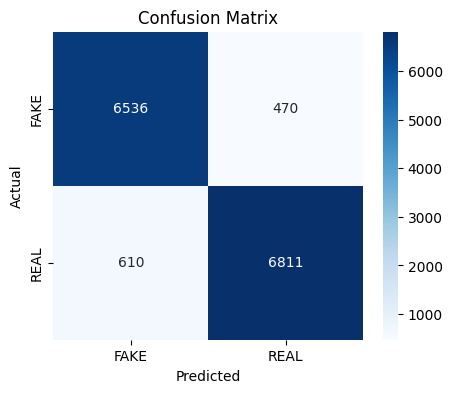

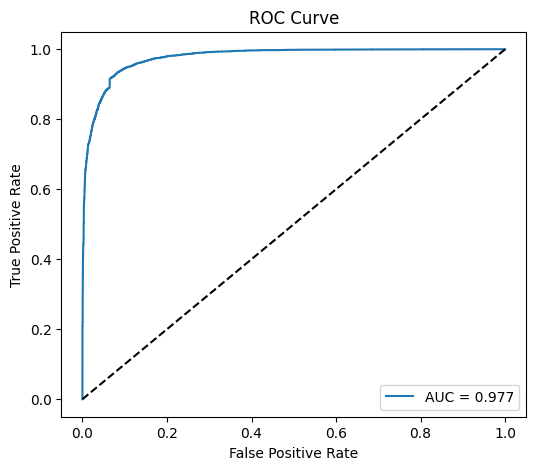

In [19]:
# 6: Final Evaluation on Test Set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(" Evaluation Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [20]:
# 7: Explainability — Top Words per Class
tfidf = best_model.named_steps['tfidf']
nb = best_model.named_steps['nb']
feature_names = tfidf.get_feature_names_out()

top_n = 20
for i, cls in enumerate(nb.classes_):
    top_features = sorted(
        zip(feature_names, nb.feature_log_prob_[i]),
        key=lambda x: x[1], reverse=True
    )[:top_n]
    print(f"Top indicative words for class {cls} ({'REAL' if cls==1 else 'FAKE'}):")
    print([word for word, _ in top_features])

Top indicative words for class 0 (FAKE):
['said', 'trump', 'mr', 'president', 'reuters', 'state', 'house', 'new', 'states', 'government', 'republican', 'united', 'people', 'clinton', 'washington', 'party', 'percent', 'united states', 'told', 'obama']
Top indicative words for class 1 (REAL):
['trump', 'clinton', 'hillary', 'people', 'obama', 'said', 'just', 'president', 'like', 'donald', 'donald trump', 'news', 'new', 'election', 'hillary clinton', 'time', 'america', 'campaign', 'media', 'white']


In [21]:
# 8: Bias Detection and Mitigation
class_counts = df['label'].value_counts()
imbalance_ratio = class_counts.min() / class_counts.max()

print("Class balance ratio:", round(imbalance_ratio, 3))
if imbalance_ratio < 0.8:
    print("Detected class imbalance → Applying upsampling of minority class...")
    df_major = df[df.label==0]
    df_minor = df[df.label==1]
    df_minor_up = resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)
    df_balanced = pd.concat([df_major, df_minor_up])
    print("Balanced dataset shape:", df_balanced.shape)
else:
    print("Classes appear balanced.")
    df_balanced = df.copy()

Class balance ratio: 0.944
Classes appear balanced.


In [22]:
# 9: Retrain on Balanced Data (Optional)
Xb = df_balanced['text']
yb = df_balanced['label']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.2, random_state=42, stratify=yb
)

best_model.fit(Xb_train, yb_train)
yb_pred = best_model.predict(Xb_test)
print("Re-evaluation after balancing:")
print("Accuracy:", round(accuracy_score(yb_test, yb_pred)*100, 2), "%")

Re-evaluation after balancing:
Accuracy: 92.51 %


In [23]:
# 10: Save Model
joblib.dump(best_model, 'FakeNews_NB_Model.pkl')
print("Model saved as FakeNews_NB_Model.pkl")

Model saved as FakeNews_NB_Model.pkl


In [35]:
# 11: Predict on New News Samples
sample_news = [
    "The Prime Minister announced new education policies today.",
    "Aliens have secretly taken over the White House, experts confirm!",

]

preds = best_model.predict(sample_news)
for news, label in zip(sample_news, preds):
    print(f"News: {news}")
    print("Prediction:", "REAL" if label==1 else "FAKE")

News: The Prime Minister announced new education policies today.
Prediction: FAKE
News: Aliens have secretly taken over the White House, experts confirm!
Prediction: REAL
